#  乳がんデータで識別を行う
目的：　決定木，SVM，ロジスティック回帰を用いて乳がん患者を識別． 

- それぞれのモデルでcross validationを行い，モデルパラメータを決定する．
- 決定したモデルで学習を行い，テストデータでの性能(accuracy, precision, recall, f-score, roc-auc)をみる．

In [5]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
np.random.seed(42)

## データ読み込み

In [10]:
# データ読込
#breast_cancer.csvを置いたディレクトリを書いてください。
data = pd.read_csv(r"C:\Users\yktft\python\M3演習\M3演習breast_cancer.csv", encoding="utf-8")
#dataの最初の4行を表示するコードを書いてください。説明変数は30個，最後の列が目的変数のラベル(1が悪性，0が良性)
data.loc[:3]

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1


In [27]:
#0から29のうちランダムに10個を抽出した配列を作成するコードを記述してください。今回はランダムに選んだ10変数で学習します。
import random
def randam_array(a, b, k):
  ns = []
  while len(ns) < k:
    n = random.randint(a, b)
    if not n in ns:
      ns.append(n)
  return ns

index = randam_array(0, 29, 10)
print(index)

# 特徴データとラベルをX, yに格納
X = data.iloc[: ,index].values # numpy array
y = data.iloc[:, -1].values #1が悪性，0が良性
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=15)

transformer = StandardScaler() #データを標準化するtransformer
X_train = transformer.fit_transform(X_train) #訓練データを標準化
#訓練データと同じtransformerで標準化してください。(fitの有無に注意)
X_test = transformer.transform(X_test)

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

[23, 14, 13, 3, 1, 24, 7, 29, 21, 11]
426
143
426
143


## 決定木を用いた学習

- CVで決めるパラメータは決定木の深さ(depth)

### 深さ2での決定木の様子

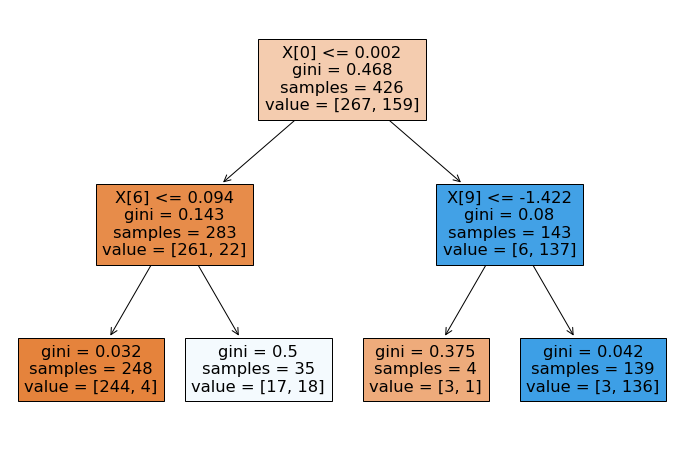

In [28]:
#深さ2の決定木のインスタンスを作成してください。
clf = DecisionTreeClassifier(max_depth=2)
plt.figure(figsize=(12, 8))
plot_tree(clf.fit(X_train, y_train), filled=True) #学習した決定木のプロット
plt.show()

valueはそのノードに含まれる各クラスのデータ数を表している．\
初めは各クラスのデータが混在しているが，それを出来るだけ分けるように決定木が構築される．

### CVにより最適な深さを決定

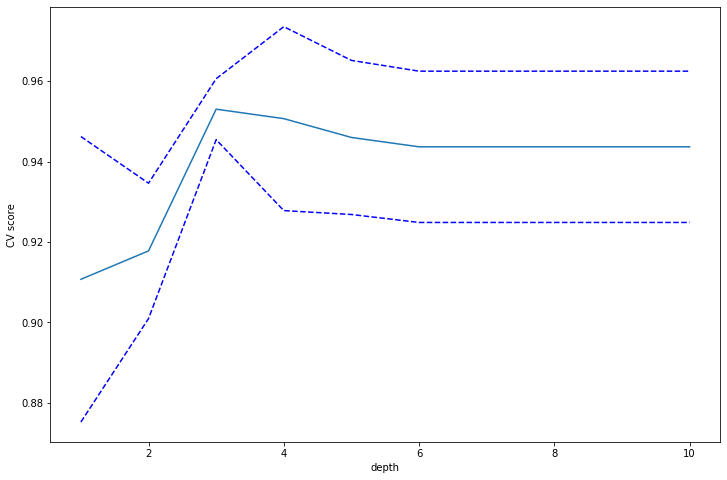

Optimal depth: 3


In [29]:
depth_s = np.arange(1, 11) #CVで試す深さパラメータのリスト
scores = [] #CVでのスコアの平均を格納するリスト
scores_std = [] #CVでのスコアの標準偏差を格納するリスト

for depth in depth_s:
    clf = DecisionTreeClassifier(max_depth = depth, random_state=42)
    #分割数5,評価指標accuracyでcross_val_scoreを算出してください。
    score = cross_val_score(clf, X_train, y_train, scoring="accuracy", cv=5)
    scores.append(np.mean(score))
    scores_std.append(np.std(score))
    
plt.figure(figsize=(12, 8))
plt.plot(depth_s, scores)
plt.plot(depth_s, np.array(scores) + np.array(scores_std), 'b--')
plt.plot(depth_s, np.array(scores) - np.array(scores_std), 'b--')
plt.xlabel("depth")
plt.ylabel("CV score")
plt.show()

opt_depth = depth_s[np.argmax(scores)] #CVでの性能が一番いい深さを選択
print("Optimal depth: {}".format(opt_depth))

### 最適な深さのモデルでtestデータでの性能を見る

## 線形SVMを用いた学習

- CVで決めるパラメータは正則化係数

### 最適な正則化パラメータをCVで求める

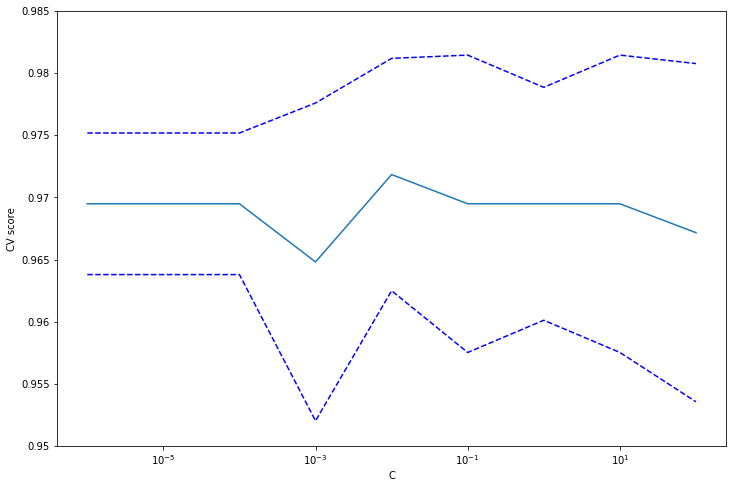

Optimal C: 0.01


In [30]:
clf = LinearSVC(random_state=42, tol=1e-5, max_iter=1000000) #線形SVMのインスタンス

C_s = np.logspace(-6, 2, 9) #今回試す正則化係数Cの候補
scores = [] #各CにおけるCV時のaccuracyを格納するリスト
scores_std = [] #各CにおけるCV時のaccuracyの標準偏差を格納するリスト

#CVにより最適なCを決定する
for C in C_s:
    clf.C = C
    #分割数5,評価指標accuracyでcross_val_scoreを算出してください。
    score = cross_val_score(clf, X_train, y_train, scoring="accuracy", cv=5)
    #CVでのスコアの平均をscoresに格納してください。
    scores.append(np.mean(score))
    #CVでのスコアの標準偏差をscores_stdに格納してください。
    scores_std.append(np.std(score))


#各CのCV scoreをプロット
plt.figure(figsize=(12, 8))
plt.semilogx(C_s, scores) #scoreの平均
plt.semilogx(C_s, np.array(scores) + np.array(scores_std), 'b--') #scoreの標準偏差のバンド
plt.semilogx(C_s, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('C')
plt.show()

opt_C = C_s[np.argmax(scores)]
print("Optimal C: {}".format(opt_C))

### 最適なパラメータのモデルでtestデータでの性能を見る

In [31]:
#決定木での学習を参考に、CVで選んだ最適なCでの学習及びテスト、各種指標とコンヒュージョンマトリクスの表示を行ってください。
#先ほど選択した一番いい深さの決定木インスタンスを作成してください。
clf = DecisionTreeClassifier(max_depth=opt_C, random_state=42)
clf.fit(X_train, y_train)
#学習した決定木でテストデータの予測を行ってください。
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred)) #各指標を計算
print(confusion_matrix(y_test, y_pred)) #コンヒュージョンマトリクスを表示

              precision    recall  f1-score   support

           0       0.63      1.00      0.77        90
           1       0.00      0.00      0.00        53

    accuracy                           0.63       143
   macro avg       0.31      0.50      0.39       143
weighted avg       0.40      0.63      0.49       143

[[90  0]
 [53  0]]


C:\Users\yktft\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## ロジスティック回帰を用いた学習

- CVで決めるパラメータは正則化係数
- 上の二つの手法と違い，データがラベルをとる確率を出力することができる

### 最適な正則化パラメータをCVで求める

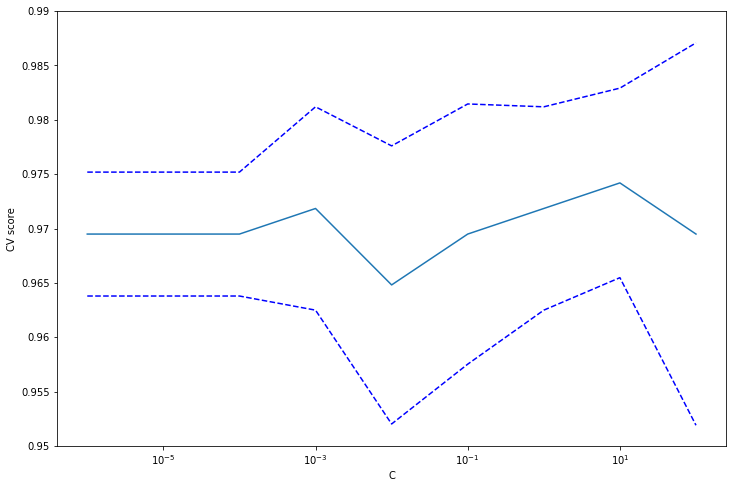

Optimal C: 10.0


In [32]:
clf = LogisticRegression(solver="liblinear", random_state=42) #ロジスティック回帰のインスタンス

C_s = np.logspace(-6, 2, 9) #今回試す正則化係数Cの候補
scores = [] #各CにおけるCV時のaccuracyを格納するリスト
scores_std = [] #各CにおけるCV時のaccuracyの標準偏差を格納するリスト

#決定木、SVMの場合のコードを参考にCV時のaccuracyとその標準偏差のリストに要素を追加するfor文を書いてください。
for C in C_s:
    clf.C = C
    #分割数5,評価指標accuracyでcross_val_scoreを算出
    score = cross_val_score(clf, X_train, y_train, scoring="accuracy", cv=5)
    #CVでのスコアの平均をscoresに格納
    scores.append(np.mean(score))
    #CVでのスコアの標準偏差をscores_stdに格納
    scores_std.append(np.std(score))

#各CのCV scoreをプロット
plt.figure(figsize=(12, 8))
plt.semilogx(C_s, scores) #scoreの平均
plt.semilogx(C_s, np.array(scores) + np.array(scores_std), 'b--') #scoreの標準偏差のバンド
plt.semilogx(C_s, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('C')
plt.show()

opt_C = C_s[np.argmax(scores)]
print("Optimal C: {}".format(opt_C))

### 最適なパラメータのモデルでtestデータでの性能を見る

In [33]:
#決定木での学習を参考に、CVで選んだ最適なCでの学習及びテスト、各種指標とコンヒュージョンマトリクスの表示を行ってください。
#先ほど選択した一番いい深さの決定木インスタンスを作成してください。
clf = DecisionTreeClassifier(max_depth=opt_C, random_state=42)
clf.fit(X_train, y_train)
#学習した決定木でテストデータの予測を行ってください。
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred)) #各指標を計算
print(confusion_matrix(y_test, y_pred)) #コンヒュージョンマトリクスを表示

              precision    recall  f1-score   support

           0       0.94      0.92      0.93        90
           1       0.87      0.91      0.89        53

    accuracy                           0.92       143
   macro avg       0.91      0.91      0.91       143
weighted avg       0.92      0.92      0.92       143

[[83  7]
 [ 5 48]]


### ロジスティック回帰の場合，出力確率が計算できる -> ROC曲線の描画

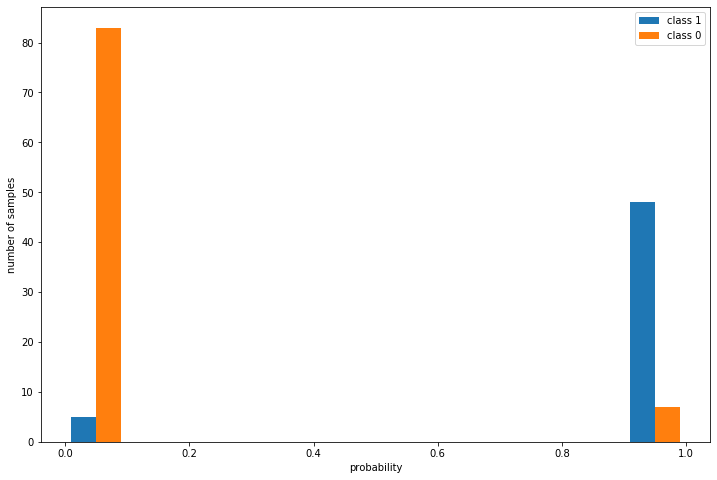

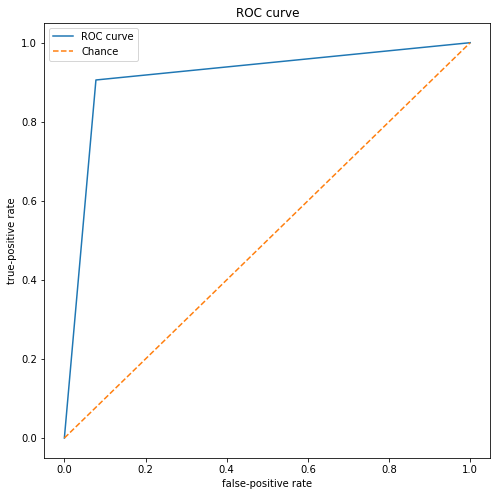

AUC score: 0.9139412997903564


In [34]:
#predict_probaメソッドを用いて各クラスになる確率を計算してください。
y_proba = clf.predict_proba(X_test)

#テストデータがクラス1となる確率のヒストグラム
plt.figure(figsize=(12, 8))
plt.hist([y_proba[y_test==1, 1], y_proba[y_test==0, 1]], stacked=False, label=["class 1", "class 0"])
plt.xlabel("probability")
plt.ylabel("number of samples")
plt.legend()
plt.show()

#ROC曲線を描画
fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1]) #各thresholdでFalse-Positiveレート，True-Positiveレートを計算
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label="ROC curve") #ROC曲線をプロット
plt.plot([0, 1], [0, 1], linestyle='--',  label='Chance') #ランダムな予測を行なった場合の曲線
plt.xlabel("false-positive rate")
plt.ylabel("true-positive rate")
plt.title("ROC curve")
plt.legend()
plt.show()

#AUC(ROC曲線の下の面積)を計算
roc_auc = auc(fpr, tpr)
print("AUC score: {}".format(roc_auc))

AUCはROC曲線の下側の面積(大きければ大きい程よい)．